In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from bs4 import BeautifulSoup

In [2]:
with open('./residents-subzone-2017.kml', 'r') as f:
    soup = BeautifulSoup(f, 'xml')

In [3]:
placemarks = [placemark for placemark in soup.find_all('Placemark')]

In [4]:
print(len(placemarks))

323


In [5]:
# reading one datapoint
sample = [
placemarks[0].get('id'),
placemarks[0].snippet,
# placemarks[0].description,
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"SUBZONE_N"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"PLN_AREA_N"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"TOTAL"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"HDB"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"ONE_TO_TWO_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"THREE_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FOUR_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FIVE_RM_EXEC_FLATS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"CONDOS_OTHER_APTS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"LANDED_PROPERTIES"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"OTHERS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"INC_CRC"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FMEL_UPD_D"}),
# [[float(num) for num in pt.split(",")] 
#  for pt in placemarks[26].Polygon.outerBoundaryIs.LinearRing.text.strip().split(" ")],
# [[float(num) for num in pt.split(",")] 
#  for pt in placemarks[26].Polygon.text.strip().replace("\n\n\n\n\n", " ").split(" ")]
]
sample

['kml_1',
 <snippet> </snippet>,
 <SimpleData name="SUBZONE_N">MARINA SOUTH</SimpleData>,
 <SimpleData name="PLN_AREA_N">MARINA SOUTH</SimpleData>,
 <SimpleData name="TOTAL">0</SimpleData>,
 <SimpleData name="HDB">0</SimpleData>,
 <SimpleData name="ONE_TO_TWO_RM">0</SimpleData>,
 <SimpleData name="THREE_RM">0</SimpleData>,
 <SimpleData name="FOUR_RM">0</SimpleData>,
 <SimpleData name="FIVE_RM_EXEC_FLATS">0</SimpleData>,
 <SimpleData name="CONDOS_OTHER_APTS">0</SimpleData>,
 <SimpleData name="LANDED_PROPERTIES">0</SimpleData>,
 <SimpleData name="OTHERS">0</SimpleData>,
 <SimpleData name="INC_CRC">A414A47E5AA4EDB5</SimpleData>,
 <SimpleData name="FMEL_UPD_D">20170927160941</SimpleData>]

In [6]:
# pm.ExtendedData.decompose()
# pm.description.decompose()
# pm.text[14:].strip().split(" ")

In [7]:
placemark_data = []

for placemark in placemarks:
    val_TOTAL = int(placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"TOTAL"}).text)
    val_SUBZONE_N = placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"SUBZONE_N"}).text
    val_PLN_AREA_N = placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"PLN_AREA_N"}).text
    placemark.ExtendedData.decompose()
    placemark.description.decompose()
    placemark_data.append([
        placemark.get('id'),
        val_TOTAL,
        val_SUBZONE_N,
        val_PLN_AREA_N,
#         [[float(num) for num in pt.split(",")] 
#          for pt in placemark.Polygon.text.strip().replace("\n\n\n\n\n", " ").split(" ")]
#         [[float(num) for num in pt.split(",")] 
#          for pt in placemark.Polygon.outerBoundaryIs.LinearRing.text.strip().split(" ")]
#         [[float(num) for num in pt.split(",")] 
#          for pt in placemark.text[14:].strip().replace("\n\n\n\n\n", " ").split(" ")]
        [[[float(num) for num in pt.split(",")] 
          for pt in ring.split(" ")] 
         for ring in placemark.text[14:].strip().split("\n\n\n\n\n")]
    ])

In [8]:
df = pd.DataFrame(placemark_data, columns=["id", "TOTAL", "SUBZONE_N", "PLN_AREA_N", "boundary"])

In [9]:
sum(df["TOTAL"])

3966030

#### Calculate the centre of district

In [10]:
def centre_boundary(boundary):
    boundary = sum(row["boundary"], [])  # flatten one level
    x_mean = sum([b[0] for b in boundary])/len(boundary)
    y_mean = sum([b[1] for b in boundary])/len(boundary)
    return x_mean, y_mean

In [11]:
df["x_centre"] = np.nan
df["y_centre"] = np.nan

In [12]:
for index, row in df.iterrows():
    x_mean, y_mean = centre_boundary(row["boundary"])
    df.at[index, "x_centre"] = x_mean
    df.at[index, "y_centre"] = y_mean

In [13]:
df.sample(5)

,id,TOTAL,SUBZONE_N,PLN_AREA_N,boundary,x_centre,y_centre
130,kml_131,10,BRAS BASAH,MUSEUM,"[[[103.849523667967, 1.29864573817247, 0.0], [...",103.849436,1.296839
270,kml_271,36790,MIDVIEW,WOODLANDS,"[[[103.795759016058, 1.43529919840128, 0.0], [...",103.791465,1.439838
86,kml_87,860,KAMPONG BUGIS,KALLANG,"[[[103.86850555995, 1.30432557431025, 0.0], [1...",103.871095,1.308293
103,kml_104,136050,TAMPINES EAST,TAMPINES,"[[[103.960885879748, 1.36060465118094, 0.0], [...",103.953300,1.356111
204,kml_205,26190,BEDOK RESERVOIR,BEDOK,"[[[103.939832818487, 1.33559548992299, 0.0], [...",103.927223,1.340049


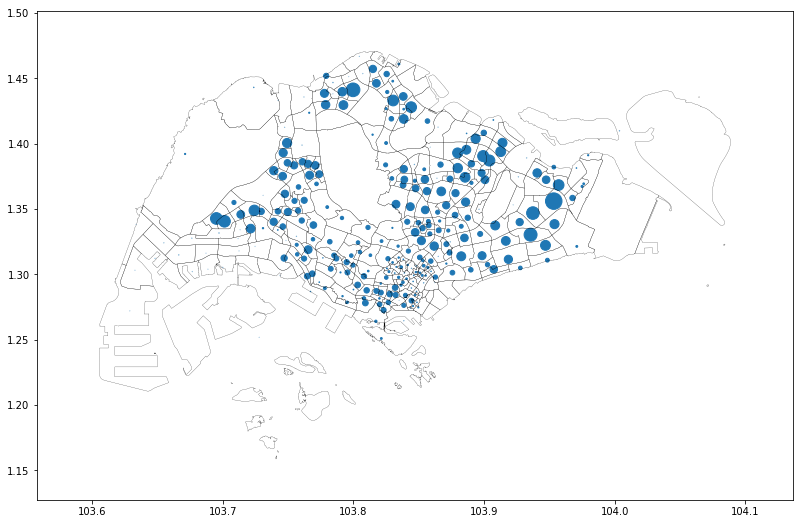

In [14]:
fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(df["x_centre"], df["y_centre"], df["TOTAL"]/500)
lines = []
for rings in df["boundary"]:
    for b in rings:
        n = len(b)
        for e,_ in enumerate(b):
            lines.append([[b[e%n][0], b[e%n][1]], [b[(e+1)%n][0], b[(e+1)%n][1]]])
lc = mc.LineCollection(lines, colors="black", linewidths=0.2)
ax.add_collection(lc)
ax.autoscale()
ax.set_aspect(1)
ax.margins(0.1)
plt.show()